In [1]:
!pip install numpy --upgrade --ignore-installed

  Using cached numpy-1.26.4-cp39-cp39-win_amd64.whl (15.8 MB)


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\chaitu\\anaconda3\\Lib\\site-packages\\numpy\\core\\_multiarray_tests.cp39-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [2]:
!pip install embeddings

In [3]:
!pip install threadpoolctl==3.1.0

In [4]:
import numpy as np
from gensim.models import KeyedVectors
from scipy.spatial.distance import cosine
import nltk
from nltk.corpus import words
nltk.download('words')
nltk.download('stopwords')
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import os
import pickle
from sklearn.manifold import TSNE
%matplotlib inline

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\chaitu\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chaitu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
def load_embeddings(file_path):
    return KeyedVectors.load_word2vec_format(file_path, binary=False)

# Compute cosine similarity between two vectors
def cosine_similarity(vec1, vec2):
    return 1 - cosine(vec1, vec2)

# Compute the differential association between two sets of words
def differential_association(word, A, B, embeddings):
    mean_cosine_A = np.mean([cosine_similarity(embeddings[word], embeddings[a]) for a in A])
    mean_cosine_B = np.mean([cosine_similarity(embeddings[word], embeddings[b]) for b in B])
    return mean_cosine_A - mean_cosine_B

# Compute effect size
def effect_size(X, A, B, embeddings):
    mean_X = np.mean([differential_association(x, A, B, embeddings) for x in X])
    std_dev = np.std([differential_association(x, A, B, embeddings) for x in X])
    return (mean_X) / std_dev

def display_gender_bias(X, Y, A, B, embeddings):
    male_vec = np.mean([embeddings[word] for word in A if word in embeddings], axis=0)
    female_vec = np.mean([embeddings[word] for word in B if word in embeddings], axis=0)
    
    for occupation in X + Y:
        if occupation in embeddings:
            occ_vec = embeddings[occupation]
            male_similarity = cosine_similarity(occ_vec, male_vec)
            female_similarity = cosine_similarity(occ_vec, female_vec)
            print(f"{occupation}: Male bias={male_similarity:.4f}, Female bias={female_similarity:.4f}")

def plot_gender_bias(X, Y, A, B, embeddings):
    male_biases = []
    female_biases = []
    labels = []

    # Compute the average vector for male and female attributes
    male_vec = np.mean([embeddings[word] for word in A if word in embeddings], axis=0)
    female_vec = np.mean([embeddings[word] for word in B if word in embeddings], axis=0)

    # Calculate biases for each occupation
    for occupation in X + Y:
        if occupation in embeddings:
            occ_vec = embeddings[occupation]
            male_bias = cosine_similarity(occ_vec, male_vec)
            female_bias = cosine_similarity(occ_vec, female_vec)
            male_biases.append(male_bias)
            female_biases.append(female_bias)
            labels.append(occupation)

    # Plotting
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(male_biases, female_biases, alpha=0.6)

    # Annotate some points
    for i, label in enumerate(labels):
        if i % 5 == 0:  # Annotate every 5th label for clarity
            plt.annotate(label, (male_biases[i], female_biases[i]))

    plt.axvline(x=0, color='grey', linestyle='--')
    plt.axhline(y=0, color='grey', linestyle='--')
    plt.title('Scatter Plot of Gender Bias by Occupation')
    plt.xlabel('Cosine Similarity to Male Vector')
    plt.ylabel('Cosine Similarity to Female Vector')
    plt.grid(True)
    plt.show()

In [41]:
def read_words_from_file(file_path):
    """
    Read words from a text file and return them as a list.
    
    Parameters:
        file_path (str): Path to the text file.
        
    Returns:
        list: List of words read from the file.
    """
    with open(file_path, 'r') as file:
        words = [line.strip() for line in file]
    return words

# Example usage
base_path = "C:/Users/chaitu/Investigating-Biases-In-Media-Representation-Across-Time"
file_path = base_path+"/adjectives_appearance.txt" 
appearance = read_words_from_file(file_path)
print(appearance)

file_path = base_path+"/adjectives_intelligencegeneral.txt"  
intelligencegeneral = read_words_from_file(file_path)
print(intelligencegeneral)

file_path = base_path+"/female_pairs.txt"  
female = read_words_from_file(file_path)
print(female)

file_path = base_path+"/male_pairs.txt" 
male = read_words_from_file(file_path)
print(male)


['alluring', 'voluptuous', 'blushing', 'homely', 'plump', 'sensual', 'gorgeous', 'slim', 'bald', 'athletic', 'fashionable', 'stout', 'ugly', 'muscular', 'slender', 'feeble', 'handsome', 'healthy', 'attractive', 'fat', 'weak', 'thin', 'pretty', 'beautiful', 'strong']
['precocious', 'resourceful', 'inquisitive', 'sagacious', 'inventive', 'astute', 'adaptable', 'reflective', 'discerning', 'intuitive', 'inquiring', 'judicious', 'analytical', 'luminous', 'venerable', 'imaginative', 'shrewd', 'thoughtful', 'sage', 'smart', 'ingenious', 'clever', 'brilliant', 'logical', 'intelligent', 'apt', 'genius', 'wise']
['she', 'daughter', 'hers', 'her', 'mother', 'woman', 'girl', 'herself', 'female', 'sister', 'daughters', 'mothers', 'women', 'girls', 'females', 'sisters', 'aunt', 'aunts', 'niece', 'nieces']
['he', 'son', 'his', 'him', 'father', 'man', 'boy', 'himself', 'male', 'brother', 'sons', 'fathers', 'men', 'boys', 'males', 'brothers', 'uncle', 'uncles', 'nephew', 'nephews']


In [42]:
len(appearance)

25

In [7]:
years = []
vocab = []
base_path_embed = "C:/Users/chaitu/Desktop/Spring'24/NLU/coha-word_sgns"
for file_name in os.listdir(base_path_embed+'/sgns/'):
    print(file_name)
    if file_name.endswith('.pkl'):
        if file_name[:4] not in  ['1880', '2000','1860','1900']:
                file_path = os.path.join(base_path_embed+'/sgns/', file_name)
                words = np.load(file_path, allow_pickle=True)
                years.append(file_name[:4])
                vocab.append(words)

1810-vocab.pkl
1810-w.npy
1820-vocab.pkl
1820-w.npy
1830-vocab.pkl
1830-w.npy
1840-vocab.pkl
1840-w.npy
1850-vocab.pkl
1850-w.npy
1860-vocab.pkl
1860-w.npy
1870-vocab.pkl
1870-w.npy
1880-vocab.pkl
1880-w.npy
1890-vocab.pkl
1890-w.npy
1900-vocab.pkl
1900-w.npy
1910-vocab.pkl
1910-w.npy
1920-vocab.pkl
1920-w.npy
1930-vocab.pkl
1930-w.npy
1940-vocab.pkl
1940-w.npy
1950-vocab.pkl
1950-w.npy
1960-vocab.pkl
1960-w.npy
1970-vocab.pkl
1970-w.npy
1980-vocab.pkl
1980-w.npy
1990-vocab.pkl
1990-w.npy
2000-vocab.pkl
2000-w.npy


In [8]:
years

['1810',
 '1820',
 '1830',
 '1840',
 '1850',
 '1870',
 '1890',
 '1910',
 '1920',
 '1930',
 '1940',
 '1950',
 '1960',
 '1970',
 '1980',
 '1990']

In [9]:
file_path_words=[]
vec_path=[]
for file_name in os.listdir(base_path_embed+'/sgns/'):
    if file_name.endswith('.pkl'):
        file_path = os.path.join(base_path_embed+'/sgns/', file_name)
        file_path_words.append(file_path)
    if file_name.endswith('.npy'):
        file_path = os.path.join(base_path_embed+'/sgns/', file_name)
        vec_path.append(file_path)

In [10]:
file_path_words

["C:/Users/chaitu/Desktop/Spring'24/NLU/coha-word_sgns/sgns/1810-vocab.pkl",
 "C:/Users/chaitu/Desktop/Spring'24/NLU/coha-word_sgns/sgns/1820-vocab.pkl",
 "C:/Users/chaitu/Desktop/Spring'24/NLU/coha-word_sgns/sgns/1830-vocab.pkl",
 "C:/Users/chaitu/Desktop/Spring'24/NLU/coha-word_sgns/sgns/1840-vocab.pkl",
 "C:/Users/chaitu/Desktop/Spring'24/NLU/coha-word_sgns/sgns/1850-vocab.pkl",
 "C:/Users/chaitu/Desktop/Spring'24/NLU/coha-word_sgns/sgns/1860-vocab.pkl",
 "C:/Users/chaitu/Desktop/Spring'24/NLU/coha-word_sgns/sgns/1870-vocab.pkl",
 "C:/Users/chaitu/Desktop/Spring'24/NLU/coha-word_sgns/sgns/1880-vocab.pkl",
 "C:/Users/chaitu/Desktop/Spring'24/NLU/coha-word_sgns/sgns/1890-vocab.pkl",
 "C:/Users/chaitu/Desktop/Spring'24/NLU/coha-word_sgns/sgns/1900-vocab.pkl",
 "C:/Users/chaitu/Desktop/Spring'24/NLU/coha-word_sgns/sgns/1910-vocab.pkl",
 "C:/Users/chaitu/Desktop/Spring'24/NLU/coha-word_sgns/sgns/1920-vocab.pkl",
 "C:/Users/chaitu/Desktop/Spring'24/NLU/coha-word_sgns/sgns/1930-vocab.pkl",

In [11]:
words = np.load(file_path_words[0], allow_pickle=True)
vecs = np.load(vec_path[0], allow_pickle=True)

keyed_vectors = KeyedVectors(vector_size=len(vecs[0]))
keyed_vectors.add_vectors(words, vecs)


In [12]:
occupation = [
    'janitor', 'bailiff', 'geologist', 'athlete', 'physicist', 
    'blacksmith', 'psychologist', 'mathematician', 'surveyor', 'mechanic', 
    'laborer', 'postmaster', 'broker', 'chemist', 'scientist', 'carpenter', 
    'sailor', 'instructor', 'sheriff', 'pilot', 'inspector', 'mason', 
    'architect', 'collector', 'operator', 'surgeon', 'driver', 'engineer', 
    'lawyer', 'clergy', 'physician', 'farmer', 'manager', 'guard', 'smith', 
    'official', 'police', 'doctor', 'professor', 'judge', 'author', 'soldier','astronomer',
    'pharmacist', 'anatomist', 'linguist', 'comedian', 'swimmer',
    'entertainer', 'politician', 'astrologer', 'philosopher', 'technician', 'deputy', 'sculptor', 'businessman',
    'industrialist', 'historian' ,'critic', 'financier', 'president', 'actor', 'singer', 'filmmaker', 'botanist',
    "statistician", "statistician", 'chauffeur', 'divers'
]

In [13]:
def list_update(words_list):
    word_list_updated=[]
    for i in words_list:
        t=False
        for j in vocab:
            if i not in j:
                t = True
        if t == False:
            word_list_updated.append(i)
    return word_list_updated

In [12]:
keyed_vectors["alluring"].all() != 0

False

In [39]:
appearance

['alluring',
 'voluptuous',
 'blushing',
 'homely',
 'plump',
 'sensual',
 'gorgeous',
 'slim',
 'bald',
 'athletic',
 'fashionable',
 'stout',
 'ugly',
 'muscular',
 'slender',
 'feeble',
 'handsome',
 'healthy',
 'attractive',
 'fat',
 'weak',
 'thin',
 'pretty',
 'beautiful',
 'strong']

In [43]:
appearance_1 = list_update(appearance)

In [44]:
len(appearance_1)

25

In [45]:
word_dict = {"appearance":appearance, "male": male, "female":female}

In [46]:
base_labels = ["appearance","female","male"]

In [47]:
def tsne_plot(model, word_dict, base_labels):
    "Creates a TSNE model and plots it"
    labels = []
    tokens = []

    color_map = {'appearance': 'green', 'female': 'red', 'male': 'blue'}

    for i in base_labels:
        for j in word_dict[i]:
            tokens.append(model[j])
            labels.append(i)
    token_new = np.array(tokens)
    tsne_model = TSNE(perplexity=15, n_components=2, init='pca', n_iter=250, random_state=23)
    new_values = tsne_model.fit_transform(token_new)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(10, 10)) 
    for i in range(len(x)):
        plt.scatter(x[i], y[i], color=color_map[labels[i]])

    # Create dummy scatter plots for legend
    for label, color in color_map.items():
        plt.scatter([], [], color=color, label=label)

    # Add legend
    plt.legend()

    # Hide x and y ticks
    plt.xticks([])
    plt.yticks([])

    plt.show()

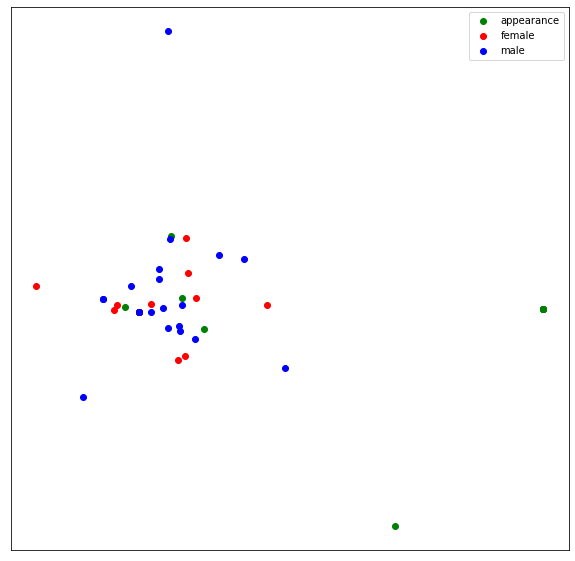

In [48]:
tsne_plot(keyed_vectors, word_dict, base_labels)

In [49]:
words = np.load(file_path_words[10], allow_pickle=True)
vecs = np.load(vec_path[10], allow_pickle=True)

keyed_vectors = KeyedVectors(vector_size=len(vecs[0]))
keyed_vectors.add_vectors(words, vecs)

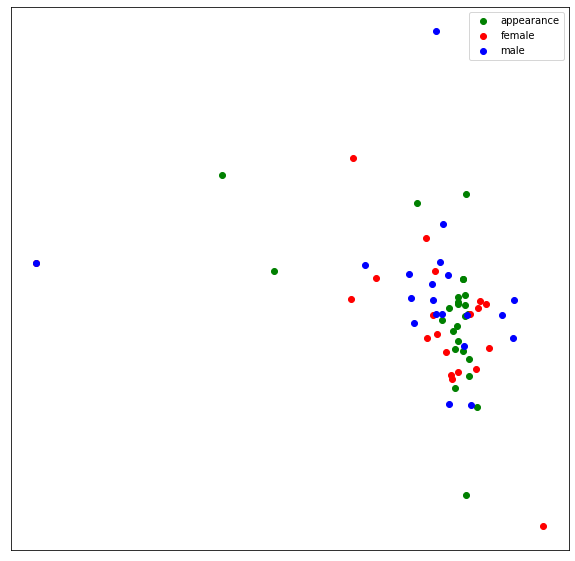

In [50]:
tsne_plot(keyed_vectors, word_dict, base_labels)

In [51]:
words = np.load(file_path_words[18], allow_pickle=True)
vecs = np.load(vec_path[18], allow_pickle=True)

keyed_vectors = KeyedVectors(vector_size=len(vecs[0]))
keyed_vectors.add_vectors(words, vecs)

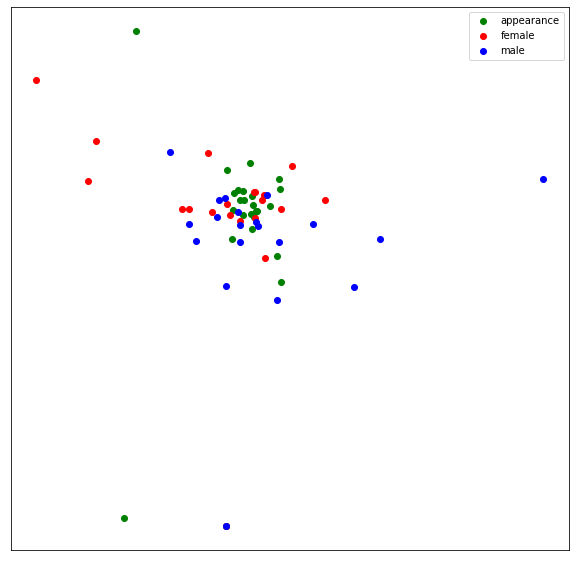

In [52]:
tsne_plot(keyed_vectors, word_dict, base_labels)